In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [2]:
!pip install --upgrade pip
!pip install seaborn
!pip install sklearn
!pip install pyproj

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and 

# SET UP

In [3]:
import pandas as pd
import numpy as np 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [4]:
df = pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', nrows=1000000)
#df= pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', skiprows=lambda x: x%2 == 1)
df_test = pd.read_csv('../input/new-york-city-taxi-fare-prediction/test.csv')
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Getting the info of the dataset

In [5]:
print(df.shape,"\n\n", df.info(),"\n\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB
(1000000, 8) 

 None 

           fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  1000000.000000    1000000.000000   1000000.000000      999990.000000   
mean        11.348079        -72.526640        39.929008         -72.527860   
std          9.822090         12.057937         7.626154         

In [6]:
df.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

In [7]:
df_test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.dropna(axis=0, inplace=True)
np.sum(pd.isnull(df))

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [10]:
df[df['fare_amount']<0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,2010-03-09 23:37:10.0000005,-2.90,2010-03-09 23:37:10 UTC,-73.789450,40.643498,-73.788665,40.641952,1
2486,2015-03-22 05:14:27.0000001,-2.50,2015-03-22 05:14:27 UTC,-74.000031,40.720631,-73.999809,40.720539,1
13032,2013-08-30 08:57:10.0000002,-3.00,2013-08-30 08:57:10 UTC,-73.995062,40.740755,-73.995885,40.741357,4
28839,2013-08-11 13:39:10.0000001,-2.50,2013-08-11 13:39:10 UTC,-73.785260,40.648442,0.000000,0.000000,1
36722,2015-04-30 15:19:45.0000003,-2.50,2015-04-30 15:19:45 UTC,-73.952187,40.790112,-73.950043,40.792839,1
42337,2015-03-09 10:29:46.0000004,-5.00,2015-03-09 10:29:46 UTC,-73.990974,40.755985,-73.980820,40.759869,1
56748,2015-06-26 01:13:18.0000002,-5.00,2015-06-26 01:13:18 UTC,-73.979797,40.743240,-73.981216,40.737240,6
58937,2010-02-19 23:47:10.0000002,-44.90,2010-02-19 23:47:10 UTC,-73.871120,40.773902,-73.676533,40.786890,1
97838,2015-06-07 02:54:14.0000004,-3.00,2015-06-07 02:54:14 UTC,-73.913246,40.766212,-73.914963,40.764065,5
102938,2010-02-10 12:33:10.0000004,-2.90,2010-02-10 12:33:10 UTC,-73.970775,40.783425,-73.973443,40.779775,1


As there are few negative and zero values for the fare, let's set the minimum fare amount 

In [11]:
# Setting minimum fare amount to zero. Base fare in NYC is $2.50
df['fare_amount'][df['fare_amount']<0] = 2.50
df[df['fare_amount']<0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count


## Data Visualizations - 1.0

### Passenger and Avg Fare Amount

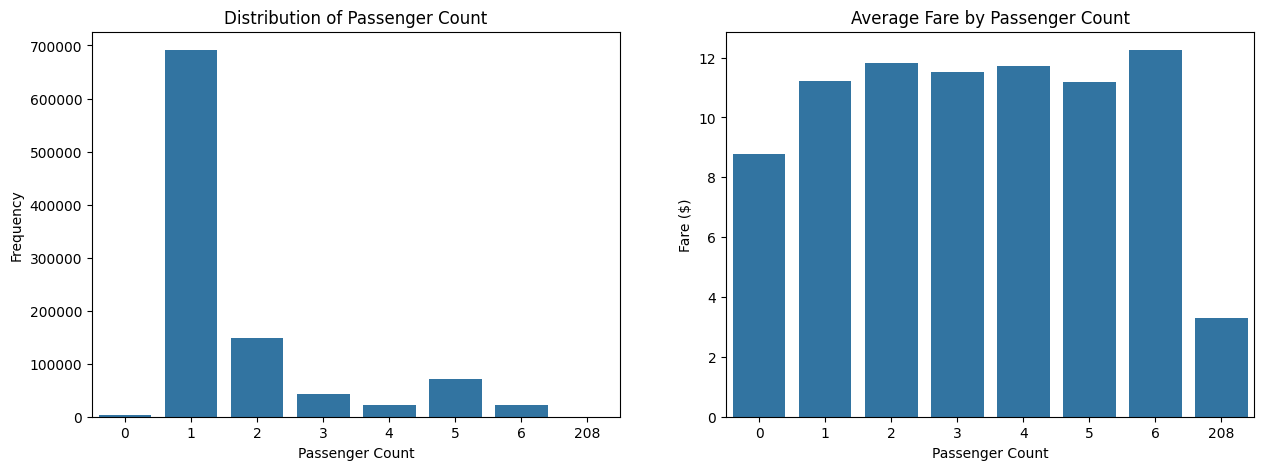

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sb.countplot(x=df.passenger_count, ax=ax[0])
ax[0].set_xlabel('Passenger Count')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Passenger Count')
sb.barplot(x=df.passenger_count, y=df.fare_amount, ax=ax[1], ci=None)
ax[1].set_xlabel('Passenger Count')
ax[1].set_ylabel('Fare ($)')
ax[1].set_title('Average Fare by Passenger Count')
fig.show()

In [13]:
df = df[df['passenger_count'] <= 6]

## Feature Extractions - 1.0

### Extracting Features from Time and Dates

In [14]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)

In [15]:
df.loc[:, 'pickup_time'] = df['pickup_datetime'].dt.time
df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_date'] = df['pickup_datetime'].dt.day
df.loc[:, 'pickup_month'] = df['pickup_datetime'].dt.month
df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.dayofweek
df.loc[:, 'pickup_year'] = df['pickup_datetime'].dt.year

df_test.loc[:, 'pickup_time'] = df_test['pickup_datetime'].dt.time
df_test.loc[:, 'pickup_hour'] = df_test['pickup_datetime'].dt.hour
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.day
df_test.loc[:, 'pickup_month'] = df_test['pickup_datetime'].dt.month
df_test.loc[:, 'pickup_weekday'] = df_test['pickup_datetime'].dt.dayofweek
df_test.loc[:, 'pickup_year'] = df_test['pickup_datetime'].dt.year

In [23]:
print(df['pickup_weekday'].isna().sum())  # Count NaN values

# Handle NaN values (fill with a default value or drop rows)
df['pickup_weekday'] = df['pickup_weekday'].fillna(0)

0


## Data Visualizations - 1.1

### Fare Amount vs Time cycles

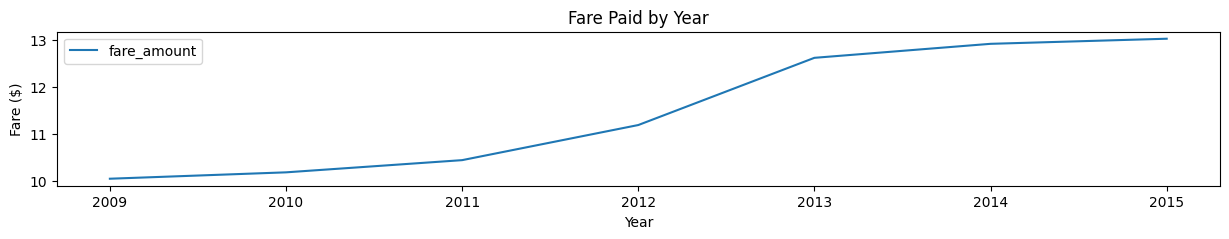

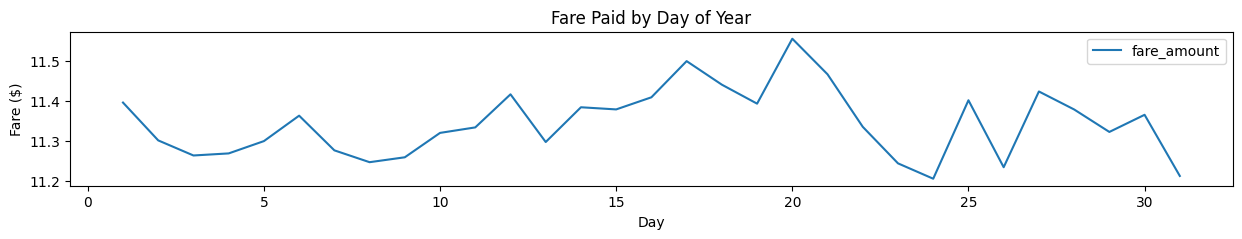

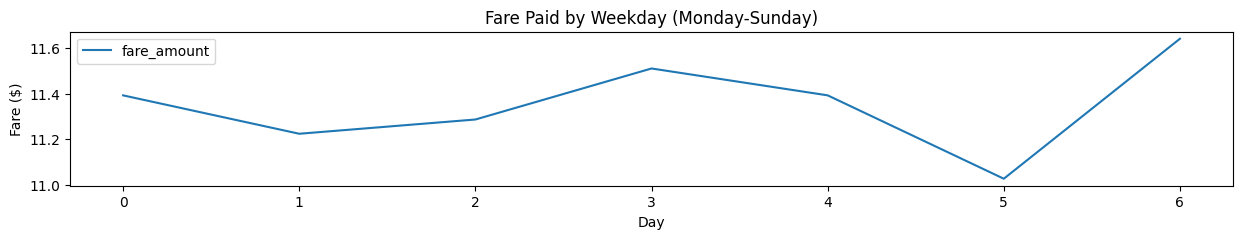

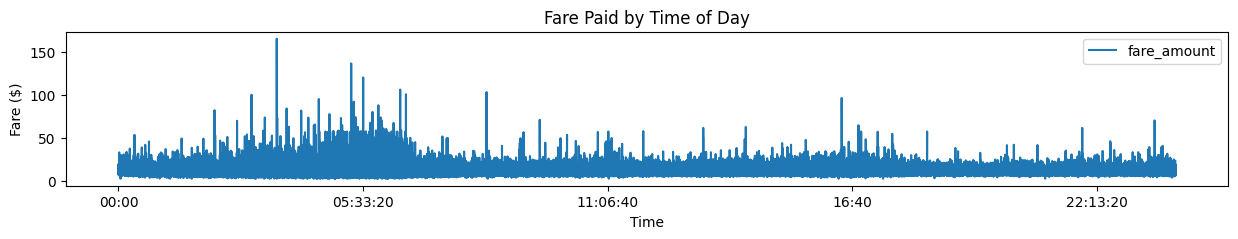

In [16]:
df.pivot_table('fare_amount', index='pickup_year').plot(figsize=(15,2))
plt.title('Fare Paid by Year')
plt.ylabel('Fare ($)')
plt.xlabel('Year')

df.pivot_table('fare_amount', index='pickup_date').plot(figsize=(15,2))
plt.title('Fare Paid by Day of Year')
plt.ylabel('Fare ($)')
plt.xlabel('Day')

df.pivot_table('fare_amount', index='pickup_weekday').plot(figsize=(15,2))
plt.title('Fare Paid by Weekday (Monday-Sunday)')
plt.ylabel('Fare ($)')
plt.xlabel('Day')

df.pivot_table('fare_amount', index='pickup_time').plot(figsize=(15,2))
plt.ylabel('Fare ($)')
plt.xlabel('Time')
plt.title('Fare Paid by Time of Day')
plt.show()

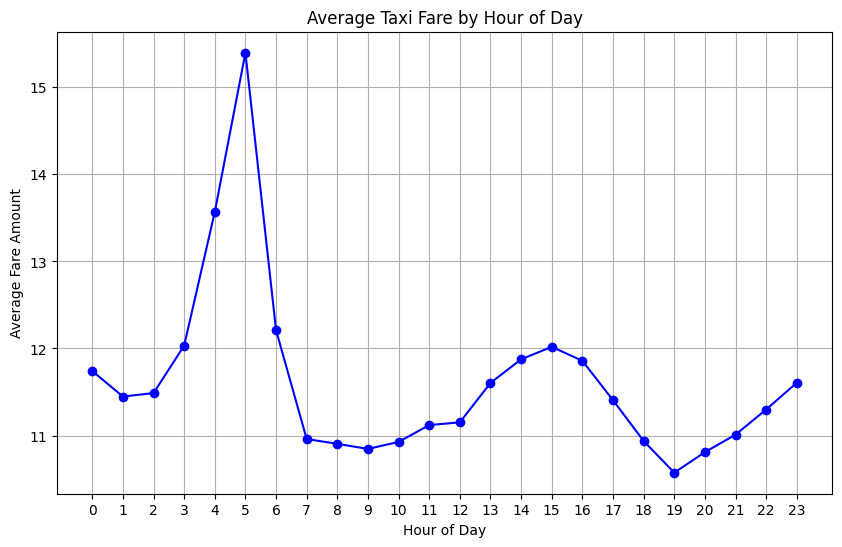

In [17]:
# Calculate the average fare for each hour
avg_fare_by_hour = df.groupby('pickup_hour')['fare_amount'].mean()

# Plotting the result
plt.figure(figsize=(10, 6))
plt.plot(avg_fare_by_hour.index, avg_fare_by_hour.values, marker='o', linestyle='-', color='b')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare Amount')
plt.title('Average Taxi Fare by Hour of Day')
plt.xticks(range(0, 24))  # Ensuring all hours are shown on x-axis
plt.grid()
plt.show()


### Analysing the distribution of pickup and dropoff points

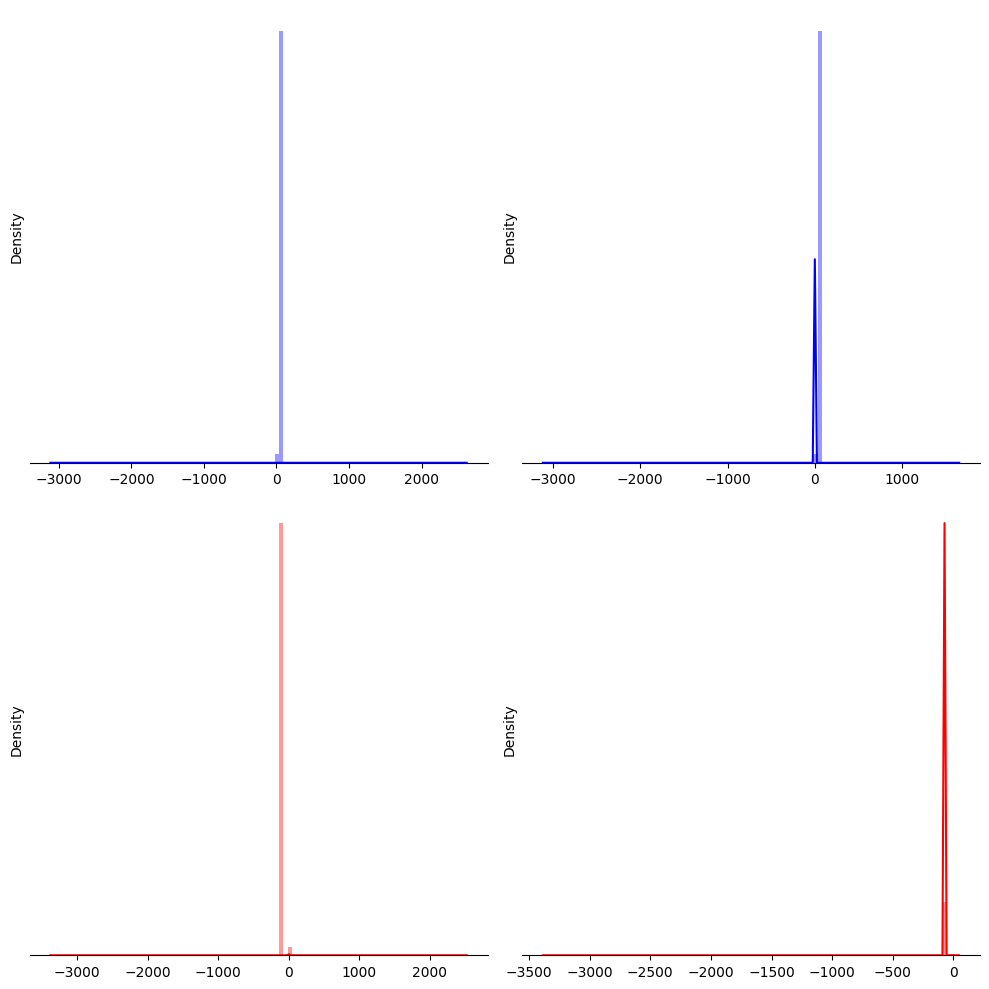

In [18]:
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sb.despine(left=True)
sb.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sb.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sb.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sb.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()


As a little amount of data points are highly affecting the distribution of the features as outliers.
Here are the results after removing the outliers that are out of NYC location points.

As this project mainly focuses on Taxi Fare prediction in NYC, looking at the few data points that are out of NYC locations would not contribute much into the model training instead they skew the model training.

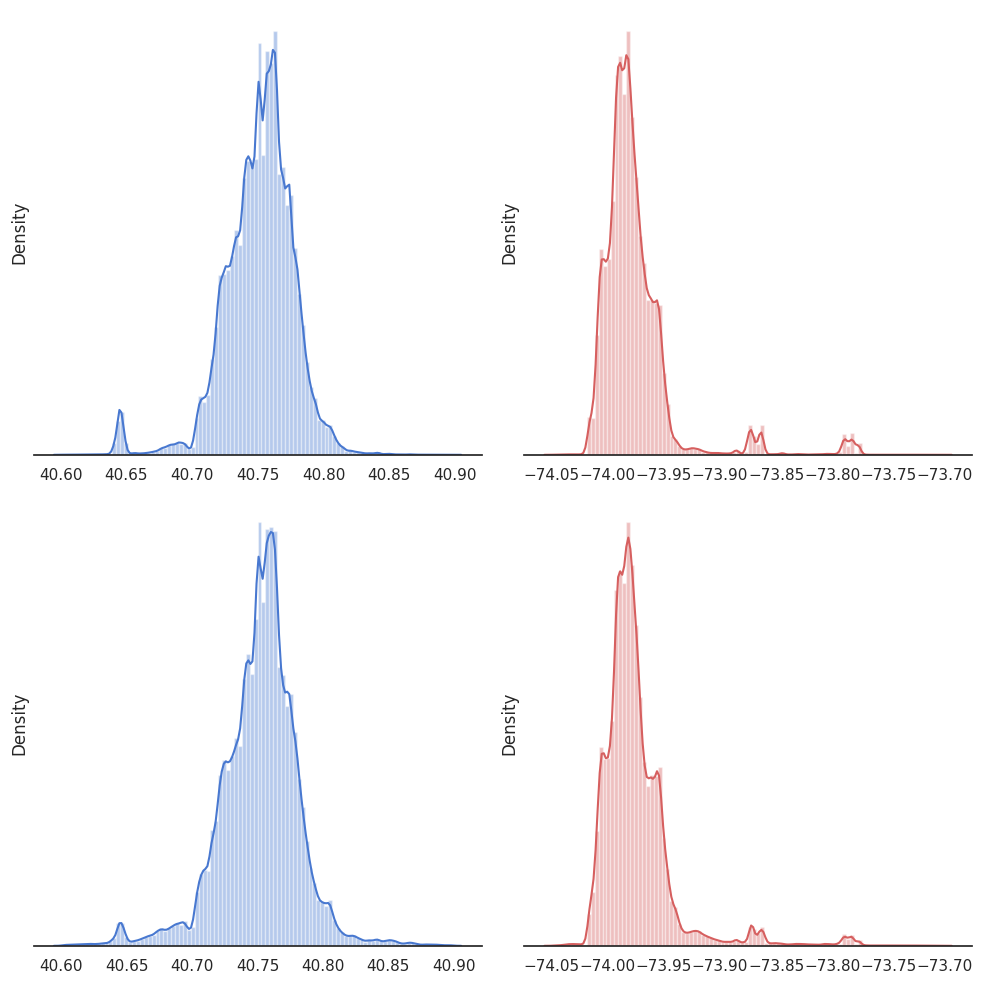

In [19]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sb.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sb.despine(left=True)
sb.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sb.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sb.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sb.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

## Feature Extractions - 1.1

In [24]:
!pip install pyproj

In [25]:
from pyproj import Geod

In [26]:
def distance(lon1,lat1,lon2,lat2):
    az12,az21,dist = Geod(ellps='WGS84').inv(lon1,lat1,lon2,lat2)
    return dist
def direction(lon1,lat1,lon2,lat2):
    az12,az21,dist = Geod(ellps='WGS84').inv(lon1,lat1,lon2,lat2)
    return az12

In [36]:
pickup_long = df.pickup_longitude.tolist()
pickup_lat = df.pickup_latitude.tolist()
dropoff_long = df.dropoff_longitude.tolist()
dropoff_lat = df.dropoff_latitude.tolist()
df = df.assign(
        sin_time=np.sin(2*np.pi*df['pickup_hour']/24),
        cos_time=np.cos(2*np.pi*df['pickup_hour']/24),
        sin_dayofyear=np.sin(2*np.pi*df['pickup_date']/365),
        cos_dayofyear=np.cos(2*np.pi*df['pickup_date']/365),
        sin_weekday=np.sin(2*np.pi*df['pickup_weekday']/6),
        cos_weekday=np.cos(2*np.pi*df['pickup_weekday']/6),
        distance=distance(pickup_long, pickup_lat, dropoff_long, dropoff_lat),
        direction=direction(pickup_long, pickup_lat, dropoff_long, dropoff_lat),
        )
df = df.assign(direction_bucket=pd.cut(df['direction'], bins=37, labels=False))

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 974729 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                974729 non-null  object             
 1   fare_amount        974729 non-null  float64            
 2   pickup_datetime    974729 non-null  datetime64[ns, UTC]
 3   pickup_longitude   974729 non-null  float64            
 4   pickup_latitude    974729 non-null  float64            
 5   dropoff_longitude  974729 non-null  float64            
 6   dropoff_latitude   974729 non-null  float64            
 7   passenger_count    974729 non-null  int64              
 8   pickup_time        974729 non-null  object             
 9   pickup_hour        974729 non-null  int32              
 10  pickup_date        974729 non-null  int32              
 11  pickup_month       974729 non-null  int32              
 12  pickup_weekday     974729 non-null 

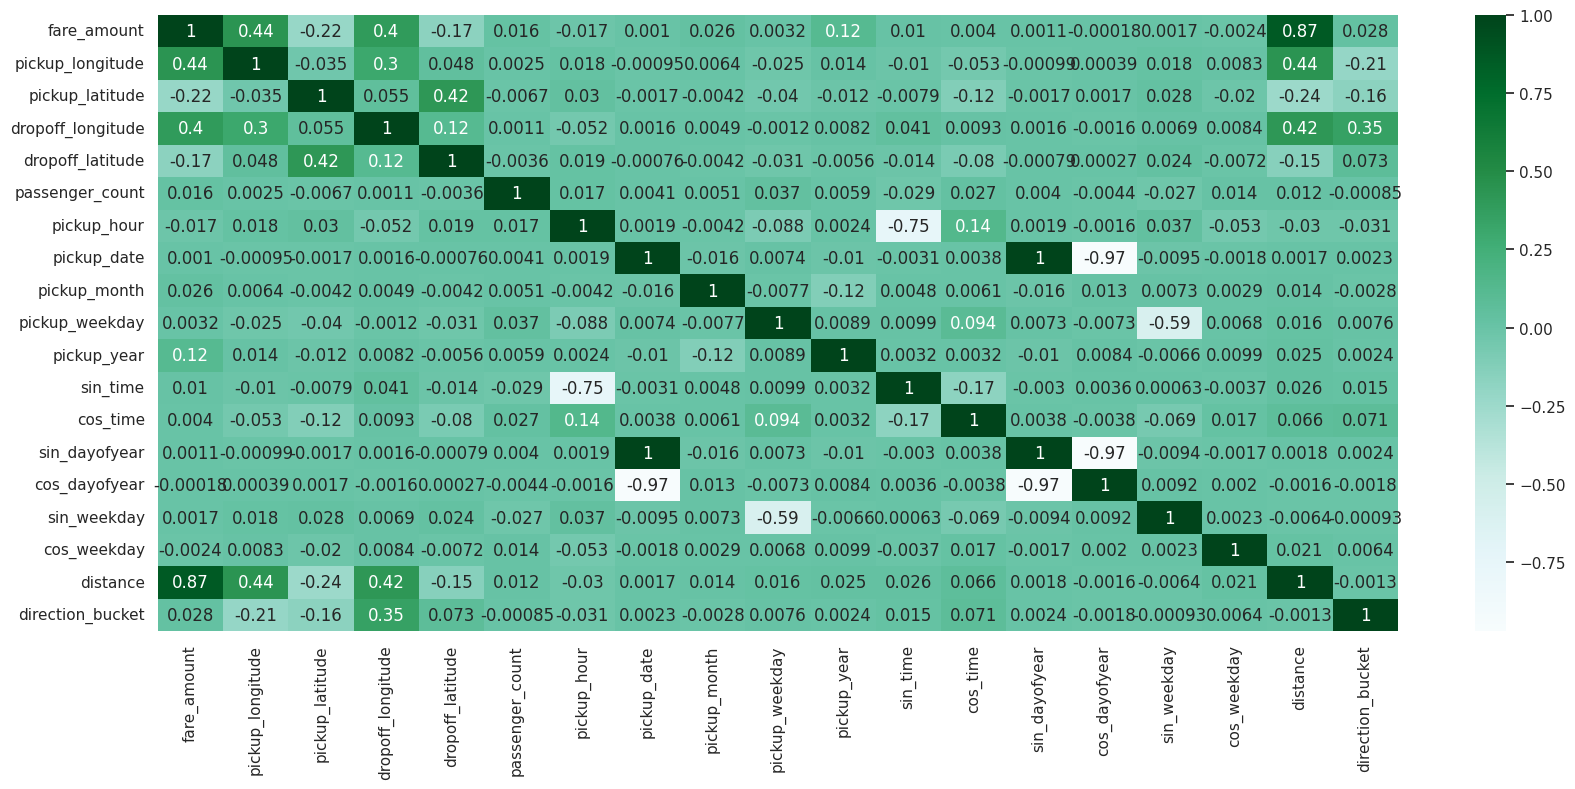

In [40]:
plt.figure(figsize = (20,8))
sb.heatmap(df.drop(['key', 'pickup_datetime','pickup_time', 'direction'], axis = 1).corr(),
           cmap ='BuGn', annot = True);

We need to remove few columns that are irrelevant for our model or are transformed into useful attributes

In [41]:
df.dropna(inplace=True)
X=df.drop(["key","pickup_datetime","fare_amount", 'pickup_time', 'direction'],axis=1)
y=df["fare_amount"]
feature_names = X.columns

X.shape, y.shape

((974729, 18), (974729,))

Standardizing the data into zero mean and unit variance

In [42]:
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 3.84762175, -1.11184563,  4.04893821, -1.29902331, -0.52374694,
         0.53542474, -0.07977378, -0.07803499, -1.55902988, -1.47076625,
        -1.151667  , -0.26573117, -0.05962747,  0.33743271,  0.02705286,
         1.20976597, -0.64595198,  1.70343148],
       [-1.19146438, -1.48786718, -0.15390826,  1.01490581, -0.52374694,
         0.38182843, -1.23142234, -1.53233273, -1.04611145, -0.93408621,
        -1.00215136, -0.60338065, -1.24384509,  1.05546113,  1.32885036,
         0.53299631,  1.48955318,  0.32904247],
       [-0.21408642,  0.3879983 , -0.51948733, -0.02852934,  0.2409094 ,
        -2.07571267,  0.26572079,  0.5036841 , -0.02027459, -0.39740616,
         0.29398274,  1.49659539,  0.28690855, -0.01536575,  0.02705286,
        -1.49731265, -0.54239146, -1.22859841],
       [-0.34295595, -0.66794799, -0.52940993,  0.22136146, -0.52374694,
        -1.4613274 ,  0.61121536, -0.65975409,  1.00556227,  0.13927388,
         1.59011684,  0.79660337,  0.62776055, -0.430

# Train-Test split

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
print(X_train.ndim)
print(y_train.ndim)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

2
1
(682310, 18)
(682310,)
(292419, 18)
(292419,)


# LINEAR REGRESSION MODEL

In [44]:
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Root Mean Square Error (RMSE) using Linear Regression on training data:", rmse_train)
print("Root Mean Square Error (RMSE) using Linear Regression on validation data:", rmse_val)

Root Mean Square Error (RMSE) using Linear Regression on training data: 4.258324789413279
Root Mean Square Error (RMSE) using Linear Regression on validation data: 4.396719067085204


In [45]:
from sklearn.model_selection import cross_val_score

np.mean(cross_val_score(model, X_train, y_train, cv=5))

0.7785801694075257

# POLYNOMIAL REGRESSION MODEL
Using different valus of degree

In [46]:
from sklearn.preprocessing import PolynomialFeatures

rmse_list=[]
for p in range(2,5):
    poly_features = PolynomialFeatures(p)
    x_train_poly = poly_features.fit_transform(X_train)
    x_valid_poly = poly_features.fit_transform(X_val)
    regr = LinearRegression().fit(x_train_poly,y_train)

    y_pred_train = regr.predict(x_train_poly)
    y_pred_val = regr.predict(x_valid_poly)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    print(f"\n The RMSE value of predicted and original Fare-Amount with polynomial degree = {p} on training data is {rmse_train}")
    print(f"\n The RMSE value of predicted and original Fare-Amount with polynomial degree = {p} on validation data is {rmse_val}")


 The RMSE value of predicted and original Fare-Amount with polynomial degree = 2 on training data is 4.011794094335524

 The RMSE value of predicted and original Fare-Amount with polynomial degree = 2 on validation data is 4.159433086660313


# RIDGE REGRESSION MODEL

In [47]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.transform(X_val)

alpha = 0.001
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_poly, y_train)

y_pred_train = ridge_model.predict(X_train_poly)
y_pred_val = ridge_model.predict(X_valid_poly)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Root Mean Square Error (RMSE) using Ridge Regression on training data:", rmse_train)
print("Root Mean Square Error (RMSE) using Ridge Regression on validation data:", rmse_val)

Root Mean Square Error (RMSE) using Ridge Regression on training data: 4.011832186078478
Root Mean Square Error (RMSE) using Ridge Regression on validation data: 4.159364370971172


In [48]:
np.mean(cross_val_score(ridge_model, X_train, y_train, cv=5))

0.7785801697125599

# LASSO REGRESSION MODEL

In [49]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.transform(X_val)

alpha = 0.001
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train_poly, y_train)

y_pred_train = lasso_model.predict(X_train_poly)
y_pred_val = lasso_model.predict(X_valid_poly)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Root Mean Square Error (RMSE) using Lasso Regression on training data:", rmse_train)
print("Root Mean Square Error (RMSE) using Lasso Regression on validation data:", rmse_val)

Root Mean Square Error (RMSE) using Lasso Regression on training data: 4.030404138131728
Root Mean Square Error (RMSE) using Lasso Regression on validation data: 4.177036221992847


In [50]:
np.mean(cross_val_score(lasso_model, X_train, y_train, cv=5))

0.7785771373549271

# Random Forest Regressor

In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 100, max_depth = 3)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Root Mean Square Error (RMSE) using Random Forest Regressor on training data:", rmse_train)
print("Root Mean Square Error (RMSE) using Random Forest Regressor on validation data:", rmse_val)

Root Mean Square Error (RMSE) using Random Forest Regressor on training data: 4.499136045763191
Root Mean Square Error (RMSE) using Random Forest Regressor on validation data: 4.636063552786583


In [52]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 50, max_depth = 5)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Root Mean Square Error (RMSE) using Random Forest Regressor on training data:", rmse_train)
print("Root Mean Square Error (RMSE) using Random Forest Regressor on validation data:", rmse_val)

Root Mean Square Error (RMSE) using Random Forest Regressor on training data: 4.065323140068471
Root Mean Square Error (RMSE) using Random Forest Regressor on validation data: 4.232566103546458


In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 30)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Root Mean Square Error (RMSE) using Random Forest Regressor on training data:", rmse_train)
print("Root Mean Square Error (RMSE) using Random Forest Regressor on validation data:", rmse_val)

Root Mean Square Error (RMSE) using Random Forest Regressor on training data: 1.4280856067432168
Root Mean Square Error (RMSE) using Random Forest Regressor on validation data: 3.7849088646976856


In [54]:
params = {
    "n_estimators":300,
    "max_depth":20,
    "min_samples_split":10,
    "min_samples_leaf":3,
    "max_features":'sqrt',
    "bootstrap":True,
    "random_state":42
}


In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(**params)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Root Mean Square Error (RMSE) using Random Forest Regressor on training data:", rmse_train)
print("Root Mean Square Error (RMSE) using Random Forest Regressor on validation data:", rmse_val)

Root Mean Square Error (RMSE) using Random Forest Regressor on training data: 2.930055177631577
Root Mean Square Error (RMSE) using Random Forest Regressor on validation data: 3.7055117409109575


In [56]:
params = {
    "n_estimators":300,
    "max_depth":15,
    "min_samples_split":15,
    "min_samples_leaf":3,
    "max_features":'sqrt',
    "bootstrap":True,
    "random_state":42
}

In [57]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(**params)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Root Mean Square Error (RMSE) using Random Forest Regressor on training data:", rmse_train)
print("Root Mean Square Error (RMSE) using Random Forest Regressor on validation data:", rmse_val)

Root Mean Square Error (RMSE) using Random Forest Regressor on training data: 3.32411082941885
Root Mean Square Error (RMSE) using Random Forest Regressor on validation data: 3.7867977834185313


In [58]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

              Feature  Gini Importance
16           distance         0.499137
0    pickup_longitude         0.156028
2   dropoff_longitude         0.128223
1     pickup_latitude         0.081259
3    dropoff_latitude         0.075859
9         pickup_year         0.020671
17   direction_bucket         0.019720
11           cos_time         0.004841
5         pickup_hour         0.003567
7        pickup_month         0.002209
10           sin_time         0.001816
13      cos_dayofyear         0.001271
6         pickup_date         0.001249
12      sin_dayofyear         0.001220
8      pickup_weekday         0.001188
15        cos_weekday         0.000765
4     passenger_count         0.000546
14        sin_weekday         0.000430


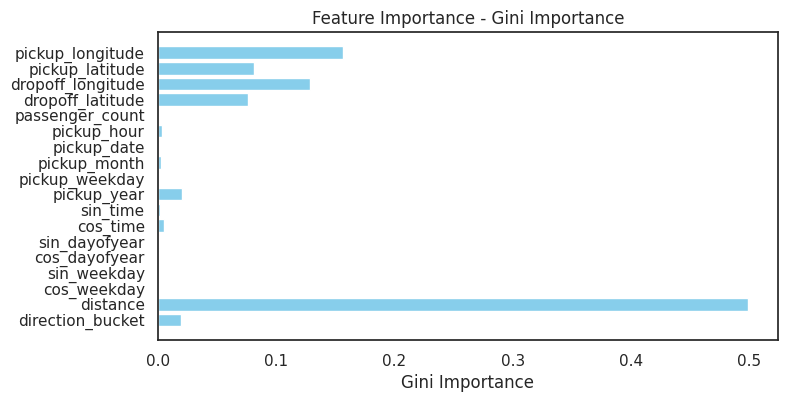

In [59]:
plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

# LightGBM models

In [60]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.1 MB/s eta 0:00:00


In [67]:
lgbm_params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'reg_sqrt': True,
    'learning_rate': 0.03,
    'num_leaves': 1200,
    'max_depth': -1,
    'max_bin': 5000,
    'num_rounds': 5000,
    'early_stopping_round': 50,
    'metric': 'rmse',
    'verbose': 100,
    'verbosity': -1
}

In [68]:
import lightgbm as lgbm

def lgbm_model(params,x_train, x_val, y_train, y_val):
    lgbm_train = lgbm.Dataset(x_train, y_train)
    lgbm_val = lgbm.Dataset(x_val, y_val)
    model = lgbm.train(params=params, train_set=lgbm_train, valid_sets=lgbm_val)
    pred = model.predict(x_val, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return model, rmse, pred

In [69]:
lgbm_final_model, lgbm_final_rmse, lgbm_final_pred = lgbm_model(lgbm_params, X_train, X_val, y_train, y_val)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.008842 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25249
[LightGBM] [Info] Number of data points in the train set: 682310, number of used features: 18
[LightGBM] [Info] Start training from score 3.162812
[LightGBM] [Debug] Trained a tree with leaves = 1200 and depth = 23
Training until validation scores don't improve for 50 rounds
[LightGBM] [Debug] Trained a tree with leaves = 1200 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 1200 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 1200 and depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 1200 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 1200 and depth = 23
[LightGBM]

In [70]:
print("Final RMSE:", lgbm_final_rmse)

Final RMSE: 3.585806304328831


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

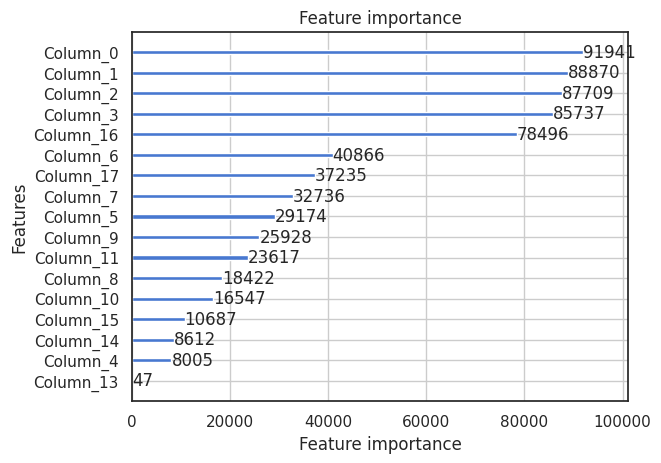

In [71]:
lgbm.plot_importance(lgbm_final_model)